# Code is by Gabriel Atkin, https://www.kaggle.com/code/gcdatkin/food-image-classification

# Food Image Classification  

Given *images of 101 different foods*, let's try to classifify the **food** present in a given image.

We will use a TensorFlow/Keras pretrained MobileNetV2 CNN to make our predictions.

# Getting Started

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

In [4]:
image_dir = Path('images')

# Creating File DataFrame

In [7]:
filepaths = list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

images = pd.concat([filepaths, labels], axis=1)

category_samples = []
for category in images['Label'].unique():
    category_slice = images.query("Label == @category") 
    category_samples.append(category_slice.sample(50, random_state=1)) # Changed from 100 to 50
image_df = pd.concat(category_samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)

In [8]:
image_df

,Filepath,Label
0,images/prime_rib/2903810.jpg,prime_rib
1,images/peking_duck/323353.jpg,peking_duck
2,images/risotto/3748280.jpg,risotto
3,images/macarons/2465398.jpg,macarons
4,images/lobster_bisque/1503601.jpg,lobster_bisque
...,...,...
5045,images/cannoli/308087.jpg,cannoli
5046,images/macarons/2668500.jpg,macarons
5047,images/waffles/1618732.jpg,waffles
5048,images/prime_rib/545595.jpg,prime_rib


In [9]:
image_df['Label'].value_counts()

Label
prime_rib         50
beef_carpaccio    50
beignets          50
bread_pudding     50
edamame           50
                  ..
grilled_salmon    50
caprese_salad     50
chicken_curry     50
takoyaki          50
samosa            50
Name: count, Length: 101, dtype: int64

# Train-Test Split

In [10]:
train_df, test_df = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=1)

# Creating Generators

In [11]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [12]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 2828 validated image filenames belonging to 101 classes.
Found 707 validated image filenames belonging to 101 classes.
Found 1515 validated image filenames belonging to 101 classes.


# Modeling

In [13]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

In [14]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(101, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)


print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,451,493 (9.35 MB)

 Trainable params: 193,509 (755.89 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

None


# Training

In [16]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=50, # Changed from 100 to 50
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 35s 371ms/step - accuracy: 0.0957 - loss: 4.2432 - val_accuracy: 0.2249 - val_loss: 3.3529
Epoch 2/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 34s 371ms/step - accuracy: 0.3382 - loss: 2.6968 - val_accuracy: 0.3296 - val_loss: 2.7675
Epoch 3/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 37s 405ms/step - accuracy: 0.5334 - loss: 1.8181 - val_accuracy: 0.3564 - val_loss: 2.6124
Epoch 4/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 33s 362ms/step - accuracy: 0.6624 - loss: 1.3101 - val_accuracy: 0.3861 - val_loss: 2.6145
Epoch 5/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 39s 427ms/step - accuracy: 0.7576 - loss: 0.9534 - val_accuracy: 0.3593 - val_loss: 2.7015
Epoch 6/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 44s 478ms/step - accuracy: 0.8487 - loss: 0.6552 - val_accuracy: 0.3805 - val_loss: 2.6381


# Results

In [17]:
results = model.evaluate(test_images, verbose=0)
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Accuracy: 34.46%


In [18]:
predictions = np.argmax(model.predict(test_images), axis=1)

cm = confusion_matrix(test_images.labels, predictions)
clr = classification_report(test_images.labels, predictions, target_names=test_images.class_indices, zero_division=0)

48/48 ━━━━━━━━━━━━━━━━━━━━ 16s 318ms/step


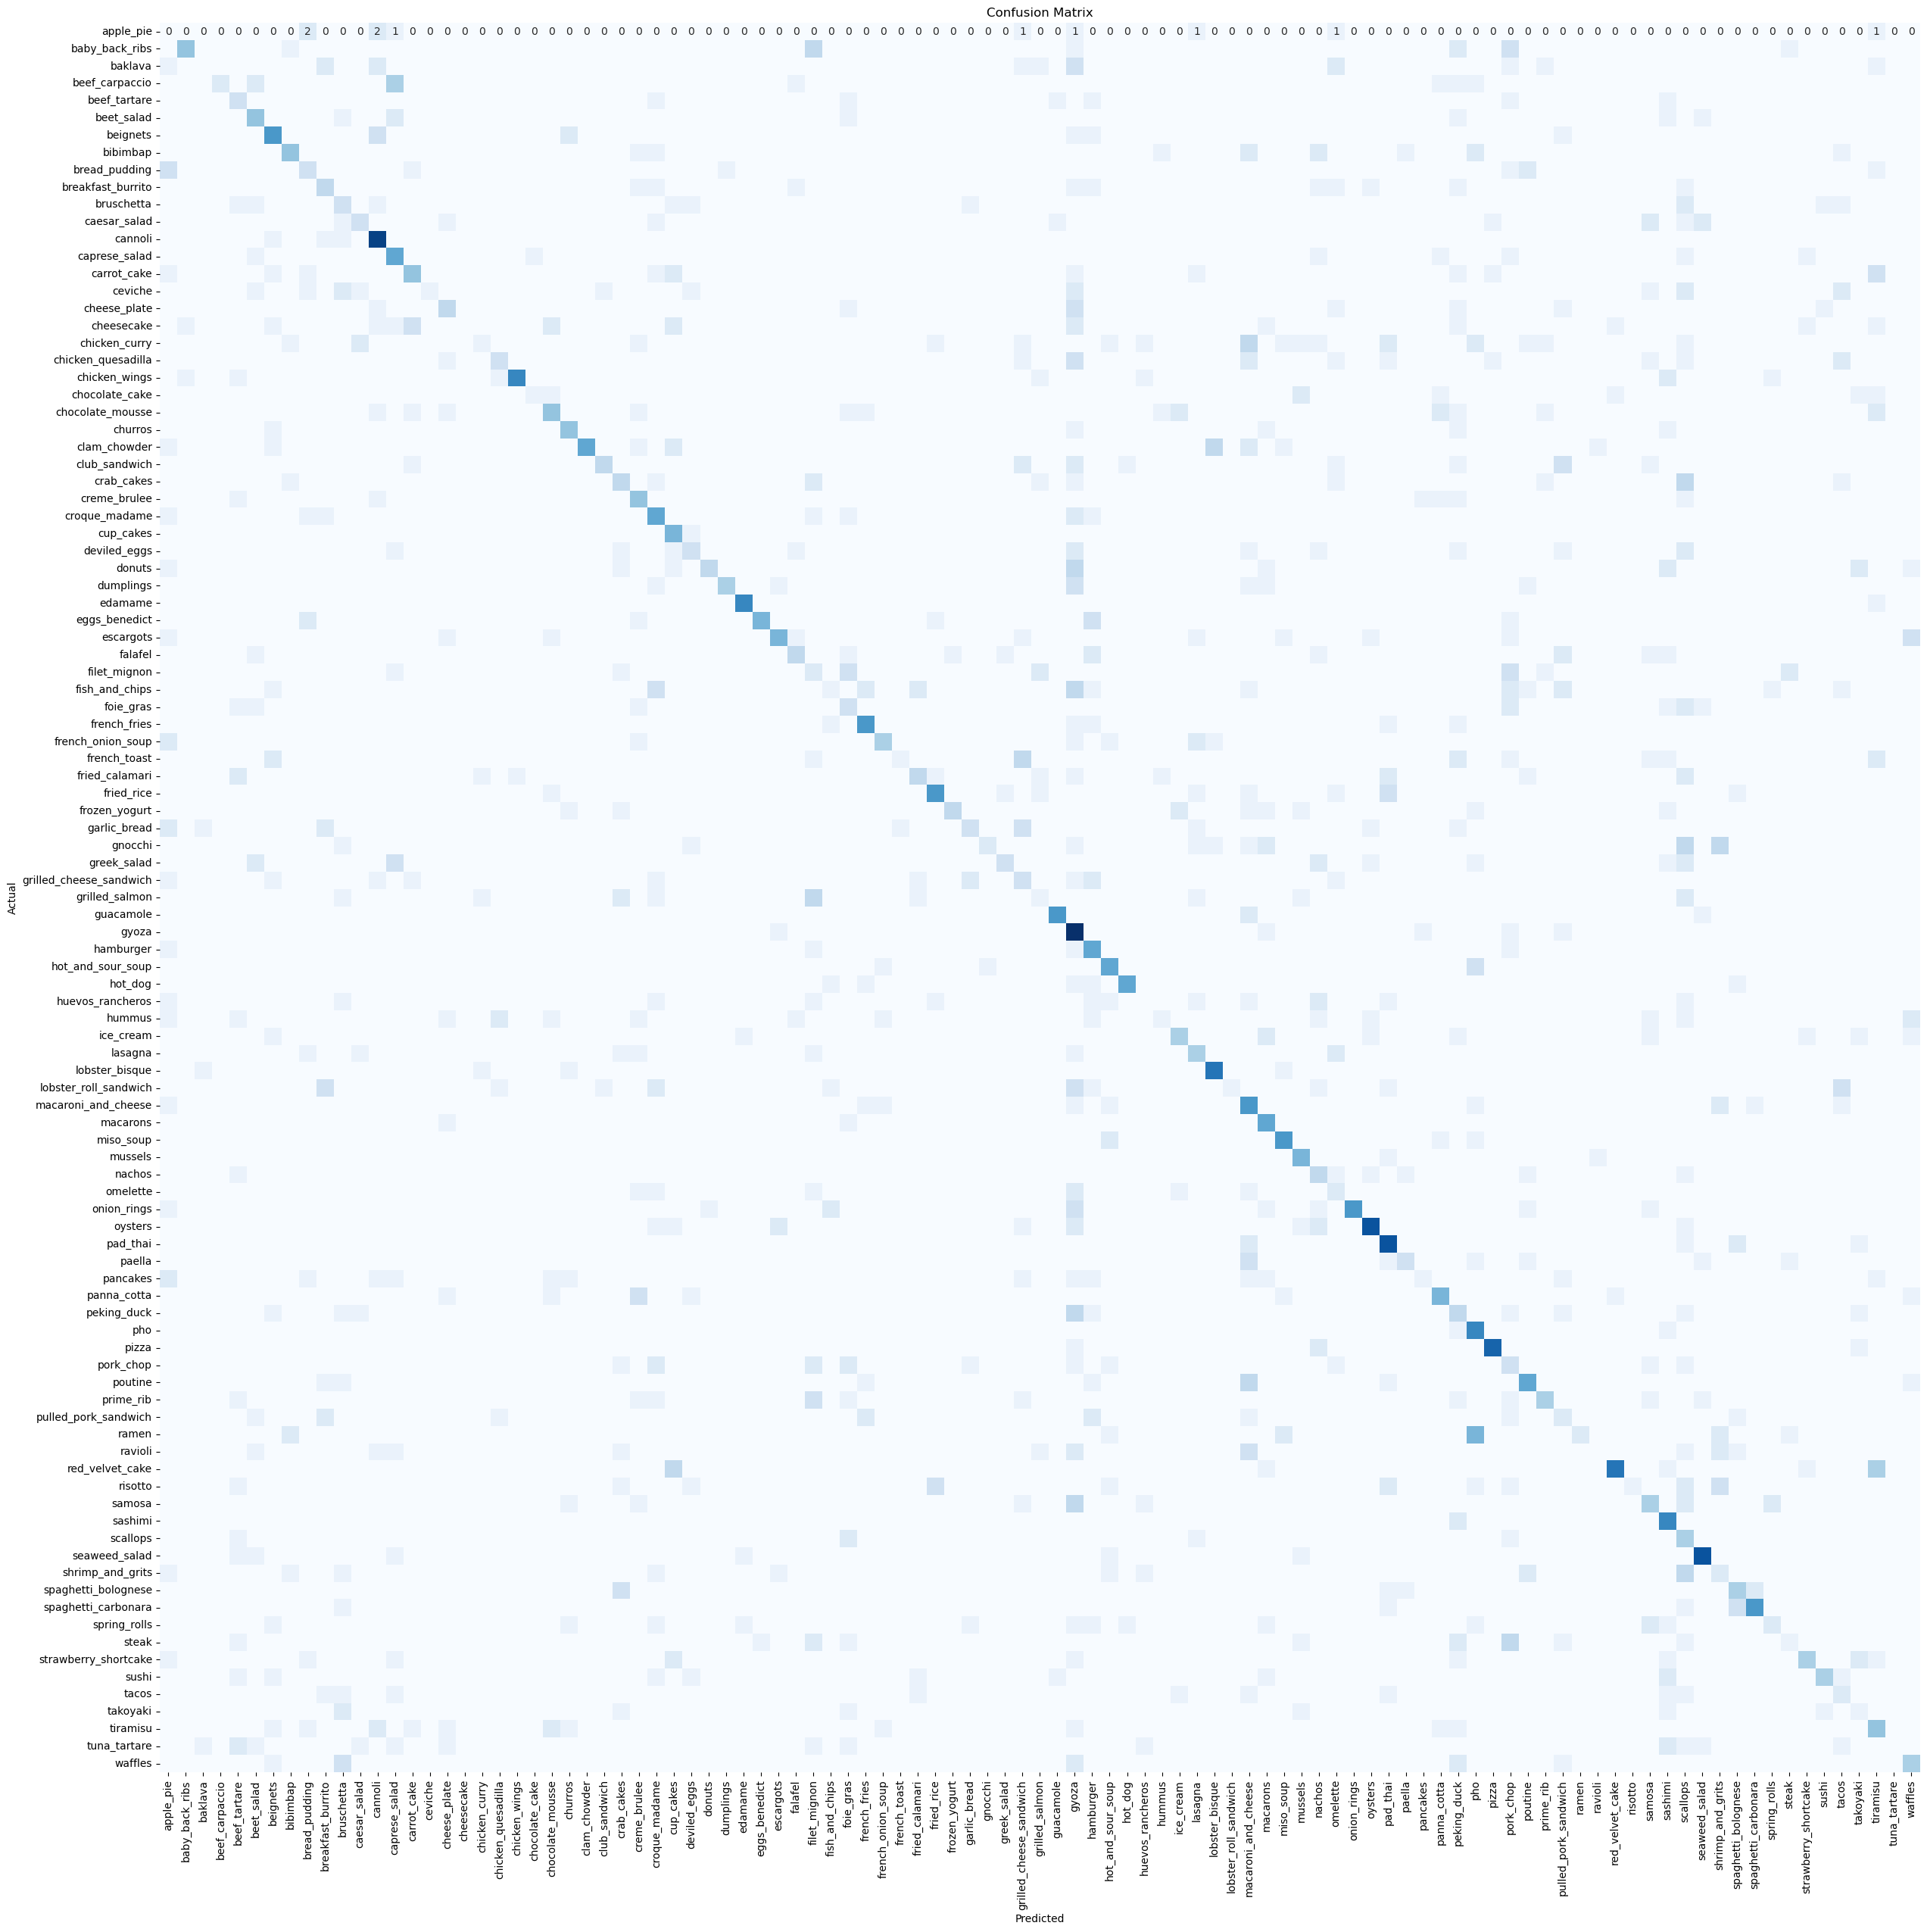

In [19]:
plt.figure(figsize=(30, 30))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(101) + 0.5, labels=test_images.class_indices, rotation=90)
plt.yticks(ticks=np.arange(101) + 0.5, labels=test_images.class_indices, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [20]:
print("Classification Report:\n----------------------\n", clr)

Classification Report:
----------------------
                          precision    recall  f1-score   support

              apple_pie       0.00      0.00      0.00        10
         baby_back_ribs       0.75      0.33      0.46        18
                baklava       0.00      0.00      0.00        15
         beef_carpaccio       1.00      0.15      0.27        13
           beef_tartare       0.16      0.33      0.21         9
             beet_salad       0.32      0.46      0.37        13
               beignets       0.38      0.53      0.44        17
               bibimbap       0.50      0.35      0.41        17
          bread_pudding       0.21      0.25      0.23        12
      breakfast_burrito       0.24      0.29      0.26        14
             bruschetta       0.14      0.23      0.18        13
           caesar_salad       0.33      0.23      0.27        13
                cannoli       0.45      0.82      0.58        17
          caprese_salad       0.29      0.

In [5]:
# Save the model in the native Keras format
model.save('food-image-classification-model-keras.keras')

NameError: name 'model' is not defined

In [ ]:
# Convert the Keras model to TensorFlow.js format
import tensorflowjs as tfjs
tfjs.converters.save_keras_model(model, 'food-image-classification-model')

print("Model saved and converted to TensorFlow.js format.")